In [1]:
import pandas as pd
import numpy as np
from scipy.stats import rv_discrete
import seaborn as sns

In [92]:
df = pd.read_excel("C:/Users/kenny/Desktop/SPFmicrodata.xlsx", sheet_name="PRUNEMP")

C:\Users\kenny\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [94]:
df.drop(df.columns[3:14], axis=1, inplace=True)

In [96]:
df.drop(df.columns[13:], axis=1, inplace=True)

In [98]:
df["DATE"]=df["YEAR"] + df["QUARTER"]/10

In [100]:
mask = df["DATE"] > 2009.1

In [102]:
df_filtered = df[mask]

In [104]:
true_values = pd.read_csv("C:/Users/kenny/Desktop/Econ 416/UNRATE.csv")

In [106]:
true_values['observation_date'] = pd.to_datetime(true_values['observation_date'])
true_values['observation_date'] = true_values['observation_date'].dt.year

In [108]:
true_values.rename(columns={'observation_date':'YEAR'}, inplace=True)
merged_df = df_filtered.merge(true_values, on='YEAR', how='left')

In [110]:
df_without_nulls = merged_df.dropna()
df_multi = df_without_nulls.set_index(['ID','DATE'])

In [112]:
df_multi

,,YEAR,QUARTER,PRUNEMP11,PRUNEMP12,PRUNEMP13,PRUNEMP14,PRUNEMP15,PRUNEMP16,PRUNEMP17,PRUNEMP18,PRUNEMP19,PRUNEMP20,UNRATE
ID,DATE,,,,,,,,,,,,,
20,2009.2,2009,2,0.0,0.0,20.0,60.0,20.0,0.0,0.0,0.0,0.0,0.0,9.3
84,2009.2,2009,2,20.0,65.0,10.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.3
407,2009.2,2009,2,0.0,0.0,5.0,70.0,15.0,10.0,0.0,0.0,0.0,0.0,9.3
411,2009.2,2009,2,5.0,15.0,25.0,30.0,20.0,5.0,0.0,0.0,0.0,0.0,9.3
420,2009.2,2009,2,0.0,0.0,35.0,55.0,10.0,0.0,0.0,0.0,0.0,0.0,9.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,2024.4,2024,4,0.0,0.0,0.0,0.0,20.0,20.0,40.0,10.0,10.0,0.0,4.0
599,2024.4,2024,4,0.0,0.0,0.0,10.0,20.0,30.0,40.0,0.0,0.0,0.0,4.0
600,2024.4,2024,4,0.0,0.0,0.0,0.0,5.0,20.0,40.0,25.0,10.0,0.0,4.0


In [114]:
prob_cols = [f'PRUNEMP{i}' for i in range(11, 21)]
df_multi['prob_sum'] = df_multi[prob_cols].sum(axis=1)
invalid_rows = df_multi[df_multi['prob_sum'] != 100]

In [116]:
for id in invalid_rows.index.get_level_values(0).unique():
    id_row = df_multi.loc[id]
    for date in id_row.index:
        row = id_row.loc[date, 'PRUNEMP11':'PRUNEMP20']
        biggest_col = row.idxmax()
        df_multi.loc[(id, date), biggest_col] = df_multi.loc[(id, date), biggest_col] - (df_multi.loc[(id, date), 'prob_sum'] - 100.00)

## Analysis

In [119]:
def sample_from_dist(intervals, probs):
    rng = np.random.default_rng()
    interval_idx = rng.choice(len(intervals), p = probs)
    left, right = intervals[interval_idx]
    return rng.uniform(left, right)

In [121]:
def find_rationality(df):
    percent_rational = pd.DataFrame(columns=["Percentage"])
    for id in df.index.get_level_values(0).unique():
        rational_count = 0
        attempts = 0
        id_row = df.loc[id]
        for date in id_row.index:
            attempts += 1
            year = id_row.loc[date, 'YEAR']
            if year < 2014:
                bins = [(5,5.9),(6,6.9),(7,7.4),(7.5,7.9),(8.0,8.4),(8.5,8.9),(9,9.4),(9.5,9.9),(10,10.9),(11,12)]
            elif 2014 < year < 2020.2:
                bins = [(3, 3.9), (4, 4.9), (5, 5.4), (5.5, 5.9), (6, 6.4), (6.5, 6.9), (7, 7.4), (7.5, 7.9), (8, 8.9), (9, 10)]
            elif 2020.1 < year < 2024.2:
                bins = [(2, 2.9), (3, 3.9), (4, 4.9), (5, 5.9), (6, 6.9), (7, 7.9), (8, 9.9), (10, 11.9), (12, 14.9), (15,16)]
            else:
                bins = [(2.1, 3.1), (3.1, 3.6), (3.7, 4.2), (4.3,4.8), (4.9, 5.4), (5.5, 6.0), (6.1, 7.1), (7.2, 8.2), (8.3, 9.8), (9.9, 10.9)]
            probs = [id_row.loc[date, f'PRUNEMP{n}'] / 100 for n in range(11,21)][::-1]
            N = 1000
            obs = np.array([])
            for i in range(N):
                obs = np.append(obs, sample_from_dist(bins,probs))
            left = np.percentile(obs, 2.5)
            right = np.percentile(obs, 97.5)
            true_value = id_row.loc[date, 'UNRATE']
            if left <= true_value <= right:
                rational_count += 1
        percent_rational.loc[len(percent_rational)] = [rational_count/attempts * 100]
    return percent_rational

In [123]:
rational_df = find_rationality(df_multi)

<Axes: xlabel='Percentage', ylabel='Count'>

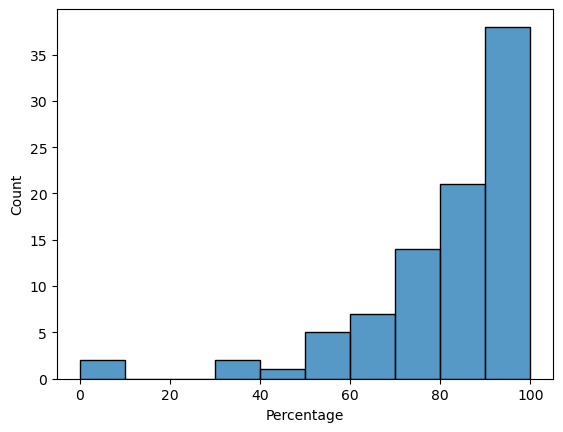

In [125]:
sns.histplot(data = rational_df["Percentage"])

In [127]:
rational_count = (rational_df['Percentage'] >= 50).sum()

In [129]:
total = (rational_df['Percentage']).count()

In [131]:
rational_count/total * 100

94.44444444444444

If a forecaster needs to have at least half of their predictions right, then 94.44% of the forecasters are rational.